# 🎶 RaagaFlow Big Data Pipeline Simulation
This notebook simulates a Big Data pipeline using Python to demonstrate the handling of Variety (a Big Data challenge).

**Key Components:**
- Simulated Kafka using Python deque
- Simulated MFCC audio feature extraction
- CNN model for genre classification (proxy for Raga)
- Real-time prediction stream
- Evaluation using confusion matrix and classification report

In [ ]:
# Installing TensorFlow
!pip install tensorflow

In [ ]:
# Importing necessary libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import librosa

In [ ]:
import kagglehub

# Downloading latest version
path = kagglehub.dataset_download("andradaolteanu/gtzan-dataset-music-genre-classification")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1


In [ ]:
import os

# Checking the main dataset directory
for root, dirs, files in os.walk(path):
    print(f"📁 {root}")
    for d in dirs:
        print("   └──", d)
    break

📁 /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1
   └── Data


In [ ]:
import os

# Explore what's inside the /Data folder
data_path = "/root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data"
for root, dirs, files in os.walk(data_path):
    print(f"📁 {root}")
    for d in dirs:
        print("   └──", d)
    break

📁 /root/.cache/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data
   └── images_original
   └── genres_original


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


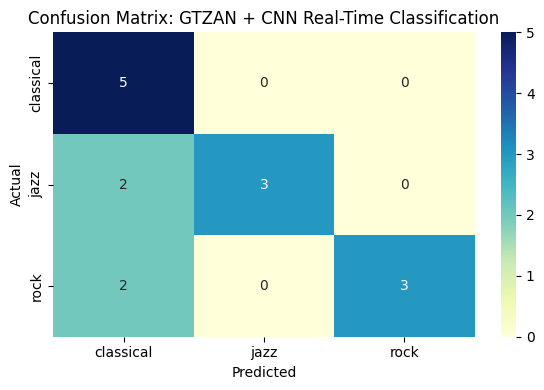

,precision,recall,f1-score
classical,0.555556,1.000000,0.714286
jazz,1.000000,0.600000,0.750000
rock,1.000000,0.600000,0.750000
accuracy,0.733333,0.733333,0.733333
macro avg,0.851852,0.733333,0.738095
weighted avg,0.851852,0.733333,0.738095


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
import librosa

# Setting the corrected path
base_path = "/root/.ca
che/kagglehub/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/versions/1/Data/genres_original"

# Defining genres to use
genres = ['classical', 'jazz', 'rock']
file_paths = []
labels = []
event_stream = deque()

# Loading 5 audio files per genre
for genre in genres:
    genre_path = os.path.join(base_path, genre)
    files = sorted([f for f in os.listdir(genre_path) if f.endswith('.wav')])[:5]
    for f in files:
        full_path = os.path.join(genre_path, f)
        file_paths.append(full_path)
        labels.append(genre)
        event_stream.append({'event': 'play', 'file': full_path, 'genre': genre})

df = pd.DataFrame({'file_path': file_paths, 'genre': labels})

# Extracting MFCCs from audio
def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfcc if mfcc.shape[1] >= 130 else np.pad(mfcc, ((0, 0), (0, 130 - mfcc.shape[1])), mode='constant')

mfcc_features = [extract_mfcc(path)[:, :130] for path in df['file_path']]
X = np.array(mfcc_features)[..., np.newaxis]
y = np.array(df['genre'])

# Encode and prepare labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42)

# Building and training CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(genres), activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=2, verbose=0)

# Simulating streaming predictions
predicted_genres = []
actual_genres = []

while event_stream:
    event = event_stream.popleft()
    mfcc = extract_mfcc(event['file'])[:, :130]
    input_data = np.expand_dims(mfcc, axis=(0, -1))
    prediction = model.predict(input_data, verbose=0)
    predicted_label = le.inverse_transform([np.argmax(prediction)])
    predicted_genres.append(predicted_label[0])
    actual_genres.append(event['genre'])

# Evaluating the model
cm = confusion_matrix(actual_genres, predicted_genres, labels=genres)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', xticklabels=genres, yticklabels=genres)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: GTZAN + CNN Real-Time Classification')
plt.tight_layout()
plt.show()

report = classification_report(actual_genres, predicted_genres, target_names=genres, output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df[['precision', 'recall', 'f1-score']]
